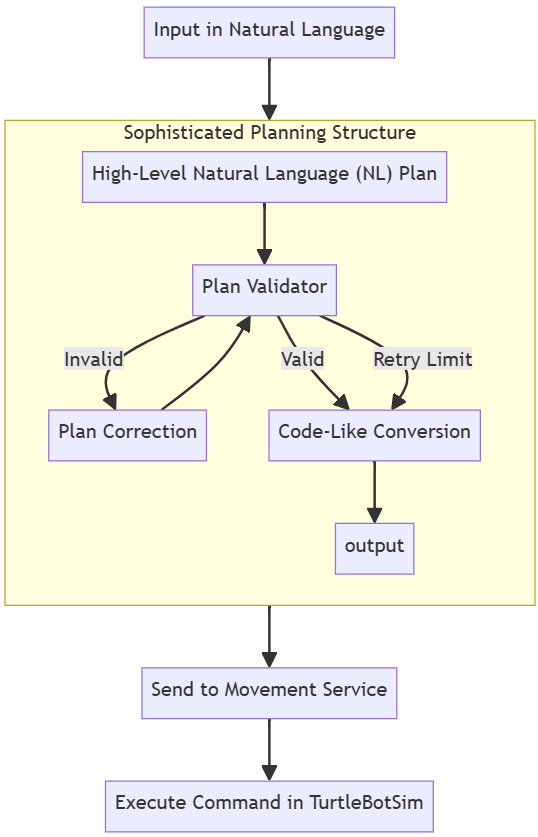

## Functions 
Architecture version 2 
3 Layer : 
- Layer 1 : High level NL Plan 
- Layer 2 : Plan Validator, if the plan is correct, go on otherwise rewrite the Plan with the correction of the Plan Validator
- Layer 3 : from the Plan Validate, if the plan is invalid, try to correct it based on the comments of the Plan Validator
- Layer 4 : from the Plan Validate, conversion into the correct format for the functions

In [1]:
import pandas as pd
import os 
from tqdm import tqdm 
from ast import literal_eval

### High level NL Plan PROMPT

In [2]:
nlp_plan_prompt =""" 
As an expert in robotic planning, your task is develop an plan for the robot to control the trajectory requested.
The user will provide the requested trajectory after keyword ##USER INPUT. Consider the ##ACTIONS during the creation of the plan.
The plan must respect the ##CONSTRAINTS when the robot is moving and the ##FORMAT of the output.

## ACTIONS  
- reach X coordinate
- reach Y coordinate
- create a curve with a given radius


## CONSTRAINTS 
- The field is a square measuring 11.0 meters in both the x and y directions.
- The robot's starting point is at x=0 and y=0, oriented along the positive x-axis (if the robot move forward it will go alongside the X). 
- Pay attention to not pass the limit of the fields (x < 0, x > 11, y < 0 ,y > 11)

## FORMAT
Return a JSON format with a single field : 
{
 "actions" : [list of actions]
 }

## EXAMPLE
user : create a semi-circle and came back to position x=0 and y=0

assistant :  {
    "actions" : ["reach X = 5.5 to avoid collision with the wall during the creation of the semi-circle", 
    "create a curve with radius 1.0 meters for 180 degrees to create a semi-circle, reaching the point x = 5.5 y = 2.0 withouth collision with the wall, the max X reached with the curve is 6.5", 
    "reach X = 0",
   "reach Y = 0"
   ]}

user : create a straight line 5 metres long and then go to the point x = 3 y = 5

assistant : {
    "actions" : ["move to X = 5 to create a straight line of 5 meters, reaching the point x = 5 y = 0", 
   "reach X = 3", "reach Y = 5"]
   }
"""

### Plan Validator PROMPT

In [3]:
plan_validator_prompt = """
As an expert in robotic planning, your task is to validate the proposed plan for the robot to control the trajectory requested.
The user will provide the requested trajectory after keyword ##ORIGINAL REQUEST and the proposed plan after keyword ##PLAN. 

The plan can be composed of the following actions:
- reach X coordinate
- reach Y coordinate
- create a curve with a given radius

## CONSTRAINTS 
- The field is a square measuring 11.0 meters in both the x and y directions.
- The robot's starting point is at x=0 and y=0, oriented along the positive x-axis (if the robot move forward it will go alongside the X). 
- Pay attention to not pass the limit of the fields (x < 0, x > 11, y < 0 ,y > 11)
- Pay attention that during a movement the robot can't go through the walls or exceed the field limits

## FORMAT
return a json with 2 fields:

- "reasoning" : a string with the analysis of each step of the plan with the reason why wheather the step is not valid
- "valid" : a string indicating if the plan is valid or not

## EXAMPLE
user : ##ORIGINAL REQUEST create a semi-circle and came back to position x=0 and y=0
##PLAN "reach X = 5.5 to avoid collision with the wall during the creation of the semi-circle", 
    "create a curve with radius 10.0 meters for 180 degrees to create a semi-circle", 
    "reach X = 0",
   "reach Y = 0"

assistant : {
    "reasoning" : "The first step is correct. The second step is wrong because the robot will hit the wall during the creation of the semi-circle, because the radius is too big indeed the robot will hit the wall at x = 11.0
    The third step would be correct, the fourth step would be correct",
    "valid" : "false"
}

user : ##ORIGINAL REQUEST create a straight line 5 metres long and then go to the point x = 3 y = 5
## PLAN "move to X = 5 to create a straight line of 5 meters, reaching the point x = 5 y = 0", 
   "reach X = 3", "reach Y = 5"
   
assistant : {
    "reasoning" : "The fist step is correct,the second step is correct, the third step is correct",
    "valid" : "true"

"""

### Plan Corrector

In [4]:
plan_corrector_prompt = """
As an expert in robotic planning, your task is to correct the proposed plan for the robot to control the trajectory requested.
You will receive the original request after keyword ##ORIGINAL REQUEST, the proposed plan after keyword ##PLAN and the evaluation of each single step of the plan after keyword ##EVALUATION.
Correct the plan based on the ##EVALUATION of each step.
Pay attention to the ##CONSTRAINTS when the robot is moving and the ##FORMAT of the output.

The plan can be composed of the following actions:
- reach X coordinate
- reach Y coordinate
- create a curve with a given radius

## CONSTRAINTS 
- The field is a square measuring 11.0 meters in both the x and y directions.
- The robot's starting point is at x=0 and y=0, oriented along the positive x-axis (if the robot move forward it will go alongside the X). 
- Pay attention to not pass the limit of the fields (x < 0, x > 11, y < 0 ,y > 11)

## FORMAT
Return a JSON format with a single field : 
{
 "actions" : [list of actions]
 }
 
## EXAMPLE 
user : ##ORIGINAL REQUEST create a semi-circle and came back to position x=0 and y=0
##PLAN "reach X = 5.5 to avoid collision with the wall during the creation of the semi-circle", 
    "create a curve with radius 10.0 meters for 180 degrees to create a semi-circle", 
    "reach X = 0",
   "reach Y = 0"
##EVALUATION "The first step is correct. The second step is wrong because the robot will hit the wall during the creation of the semi-circle, because the radius is too big indeed the robot will hit the wall at x = 11.0
    The third step would be correct, the fourth step would be correct",

assistant : {
    "actions" : ["reach X = 5.5 to avoid collision with the wall during the creation of the semi-circle", 
    "create a curve with radius 1.0 meters for 180 degrees to create a semi-circle, reaching the point x = 5.5 y = 2.0 withouth collision with the wall, the max X reached with the curve is 6.5", 
    "reach X = 0",
   "reach Y = 0" ]
    }

"""

### Code-like conversion PROMPT

In [5]:
code_like_conversion_prompt = """
As an expert in robotic programming, your task is to convert a Natural Language Plan into a sequence of code-like instructions.
The ##ORIGINAL REQUEST and the ##PLAN will be provided by the user. 
The ##PLAN can be composed of the following actions:
- reach X coordinate
- reach Y coordinate
- create a curve with a given radius

The code-like instructions are : 
- move_to_x(x_destination : float ) : this function moves the robot to a given value of x, keeping the current value of y. x_destination should be 0<x<11
- move_to_y(y_destination : float ) : this function moves the robot to a given value of y, keeping the current value of x. y_destination should be 0<y<11. 
- create_curve(circle_portion : float , curve_radius : float) : this function creates a portion of a circle (you must specify the degree) with a radius equal to the curve radius. Positive values of cirle_portion create a counter-clockwise circle, negative values create a clockwise circle.

## FORMAT
Return the list of functions to use to solve the user input, each action should have a JSON format : 
{ 
	"functions" : [{ "function_name" : { "var1" : val1 , "var2" : val2… } },..]
}

## EXAMPLE

user : ##ORIGINAL REQUEST 
create a semi-circle and came back to position x=0 and y=0
##PLAN
{
    "actions" : ["move straight 1.0 meters to avoid the limit of the field to x=1 y=0", "curve left with radius 1.0 meters until a semi-circular path is created, reaching the point x = 1, y = 2.55 and oriented toward X negative", 
    "rotate 90 degrees anticlockwise to be oriented toward the Y negative", "move straight 1.27 meters to reach the point x = 1, y = 0 with orientation toward the Y negative",
    "rotate 90 degrees clockwise to be oriented toward the X negative", "move straight 1.0 meters to reach the point x = 0, y = 0"]
}

assistant : {
	"functions" : [
	{"move_to_x" : { "x_destination": 2.0}  } , {"create_curve" : { "circle_portion": 180.0 , "curve_radius"  : 1.0 }  },{"move_to_y" : { "y_destination": 0.0}  },{"move_to_x" : { "x_destination": 0.0}  }
	]
}
"""

In [6]:
from openai import OpenAI, AzureOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pprint import pprint
import ast
import os 
from dotenv import load_dotenv
load_dotenv('.env.local')



def gpt_chat_completion(model : str ,messages : list[dict], temperature: float = 0.0, frequency_penalty: float = 0.0 , max_tokens: int = None): 
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY") )
    completion = client.chat.completions.create(
        model=os.getenv("OPENAI_MODEL") if model is None else model,
        messages=messages,
        temperature=temperature,
        seed = 42,
        frequency_penalty = frequency_penalty,
        #max_tokens=max_tokens,
        )
    return completion.choices[0].message.content



def claude_completion(messages : list[tuple], model='claude-3-opus-20240229') : 
    llm = ChatAnthropic(model=model,
                    temperature=0,
                    max_tokens=1024,
                    api_key=os.getenv("ANTHROPIC_API_KEY"),
                    
                    )
    prompt = ChatPromptTemplate.from_messages(
        messages=messages
    )

    chain = prompt | llm | StrOutputParser()
    msg = chain.invoke(messages)
    
    return msg #msg.content

In [7]:
questions = [
    "create a rectangle of dimension X = 3 m and Y = 1 m",
	"crea un quadrato di lunghezza 2 metri",
	"create a circle respecting the limits of the fields"  ,
	"reach x = 2.5 and y= 9.0",
	"go to point x=6 y=7 passing through x=2 and y=2",
	"create a square and than a circle",
	"create a rectangle of x = 5 and y = 3 and than go to position x=9 and y=9",
	"create a U trajectory",
	"Create a square with an arch as side",
 "Create 3/4 of a circle and go to point x = 6 y= 9"
]*3

In [8]:
import logging
from tqdm import tqdm
from time import time
tot_time = 0
max_iterations = 3
for model in [ "gpt-4o"]: #"gpt-3.5-turbo-0125" ]: ,
    results = list()
    for  question in tqdm(questions) : 
        init_time = time()
        messages=[
            {"role": "system", "content": nlp_plan_prompt},
            {"role": "user", "content": "## USER INPUT\n" + question}
                ]
        logging.info("High level plan completed")
        high_level_plan = gpt_chat_completion(model, messages, temperature=0.0)
        json_plan = high_level_plan[ high_level_plan.find("{"): high_level_plan.rfind("}")+1]  
        for i in range(max_iterations):
            validator =  [
                {"role": "system", "content": plan_validator_prompt},
                {"role": "user", "content": f"## ORIGINAL REQUEST {question} ## PLAN \n{json_plan}"}
            ]
            valid = gpt_chat_completion(model, validator, temperature=0.0)
            try : 
                valid = literal_eval(valid)
                if valid['valid'] == "true" : 
                    break     
                
                else : 
                    print("Plan is not valid retrying")
                    corrector = [
                        {"role": "system", "content": plan_corrector_prompt},
                        {"role": "user", "content": f"##ORIGINAL REQUEST {question} ##PLAN \n{json_plan} \n ##EVALUATION {valid['reasoning']}"},]
                    json_plan = gpt_chat_completion(model, corrector, temperature=0.0)
            except :
                print("Error in parsing the response")
                continue
        
        code_like_messages = [
            {"role": "system", "content": code_like_conversion_prompt},
            {"role": "user", "content": f"##ORIGINAL REQUEST {question} ##PLAN \n{json_plan}"}
        ]
        code_plan = gpt_chat_completion(model, code_like_messages, temperature=0.0)
        
        end_time = time()
        tot_time += end_time - init_time
        
        results.append({"question" : question , "high_level_plan" : json_plan , "valid" :valid , "code_plan" : code_plan , "time" : end_time - init_time })
    tot_time = tot_time / len(questions)
    print(f"Average time for model {model} : {tot_time}")
    df = pd.DataFrame(results)
    df.to_excel(f"functions_{model}_results.xlsx", index=False)


 17%|█▋        | 5/30 [00:50<04:02,  9.72s/it]

Plan is not valid retrying
Plan is not valid retrying


 20%|██        | 6/30 [01:26<07:33, 18.90s/it]

Plan is not valid retrying
Plan is not valid retrying
Plan is not valid retrying


 27%|██▋       | 8/30 [02:23<08:21, 22.82s/it]

Plan is not valid retrying
Plan is not valid retrying


 50%|█████     | 15/30 [03:58<02:43, 10.88s/it]

Plan is not valid retrying
Plan is not valid retrying


 60%|██████    | 18/30 [04:54<02:53, 14.45s/it]

Plan is not valid retrying
Plan is not valid retrying
Plan is not valid retrying


 83%|████████▎ | 25/30 [06:16<00:41,  8.36s/it]

Plan is not valid retrying
Plan is not valid retrying


 87%|████████▋ | 26/30 [06:45<00:58, 14.53s/it]

Plan is not valid retrying


100%|██████████| 30/30 [07:37<00:00, 15.24s/it]


Average time for model gpt-4o : 15.236461265881855
